The first thing we have to do arrange the data properly to help train the model. The data can be download from **[here](https://github.com/zo7/painter-by-numbers/releases/tag/data-v1.0)**. It has been preprocessed by some awesome person to reduce size of the images

The downloaded data is consists of 
- **train** : ~75K images 
- **test** : 23817 images

Apart from that we are provided with a file called **train_info.csv** that has the following format: 

**filename,hash(artistname),title,style,genre,data**


102257.jpg,5b39c876740bfc1cfaf544721c43cac3,Uriel,Color Field Painting,abstract,1955.0                                 

So the first thing we have to do is sort all the images into groups of artist hashnames. This can be done in fact with a line of bsshscript
```
cat train_info.csv | tail -n +2 | cut -d, -f2 | sort | uniq | xargs -L 1 mkdir
```

The function performed by each of the following is as follows : 
- **cat** : lists the contents of the csv file
- **tail -n +2** : skips the first line of the csv which are the labels 
- **cut -d, -f2** : returns the 2nd column(given by the flag -f) of the data. -d is used to show the delimeter
- **sort** : sorts the data returned 
- **uniq** : removes duplicate lines. Needs sort before it as it removes only duplicate lines grouped togetner
- **xargs -L 1 mkdir**: takes the input of the previous command one at a a time ( -L 1 ensures that) and attatches it to the mkdire command

And hence this creates the directories with all the hash names

Next we have to move the images into respective artist hashname directories as given in the csv file. I am sure we can do it using python but since I was keen to practice more bash I decided to stick to that. The following command is all that is needed. 

```
cat ../train_info.csv | cut -d, -f1,2 | tr "," " " | xargs -L 1 bash -c 'mv $0 $1' 

```

i am sure there is a much more efficient way to do but I had to scratch my bash itch. The function performed by the commands is as follows : 
- **cat** : lists the contents of the csv file
- **tail -n +2** : skips the first line of the csv which are the labels 
- **cut -d, -f1,2** : returns the 1st and 2nd column(given by the flag -f) of the data. -d is used to show the delimeter.
- **tr "," " "** : replaces the , with a space 
- **uniq** : removes duplicate lines. Needs sort before it as it removes only duplicate lines grouped togetner
- **xargs -L 1 bash -c 'mv $0 $1'**: takes the input of the previous command one at a a time. Moves the image (\$0 : first argument) to the directory ($1 : second argument)


The next thing to do is to generate some valid data which will help fitting our model. Python offers some really great libraries which do this and I do plan to use them in the near future but for now I will stick to bash as it makes for good practice. So I wrote the following script that takes 10% of the training data and copies it into the corresponding validation directories.




Next I used a couple of bash commands to create a sample of the data so that I can initially test my data on smaller subset. The following commands were used

```
ls train/ | head -500 | xargs -L 1 -I {} mkdir sample/train/{}
ls train/ | head -500 | xargs -L 1 -I {} mkdir sample/valid/{}
ls train/ | head -200 | xargs -L 1 -I {} cp -a train/{}/. sample/train/{}/
ls train/ | head -200 | xargs -L 1 -I {} cp -a valid/{}/. sample/valid/{}/
```

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import os, json
from glob import glob
from matplotlib import pyplot as plot

In [3]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [12]:
#path="data/painter-by-numbers/"
path="data/painter-by-numbers/sample/"

In [5]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## Starting model creation and finetuning

In [7]:
vgg = Vgg16()

In [17]:
batches = vgg.get_batches(path+"train/", batch_size=4)
val_batches = vgg.get_batches(path+"valid/", batch_size=4)

Found 9070 images belonging to 200 classes.
Found 928 images belonging to 200 classes.


In [18]:
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
9070/9070 [==============================] - 262s - loss: 7.4438 - acc: 0.2469 - val_loss: 6.0270 - val_acc: 0.3772


In [27]:
img, labels = next(batches)
print(imgs)

[[[[ 118.  128.   69. ...,   45.   44.   51.]
   [ 127.  130.   65. ...,   32.   33.   43.]
   [ 115.  126.   68. ...,   36.   37.   45.]
   ..., 
   [ 142.  144.  141. ...,   58.   48.   43.]
   [ 137.  138.  138. ...,   57.   45.   36.]
   [ 131.  129.  130. ...,   54.   47.   37.]]

  [[ 115.  125.   66. ...,   43.   41.   48.]
   [ 124.  127.   62. ...,   30.   30.   40.]
   [ 112.  123.   65. ...,   34.   34.   42.]
   ..., 
   [ 136.  138.  135. ...,   55.   44.   39.]
   [ 127.  128.  129. ...,   51.   39.   29.]
   [ 124.  123.  124. ...,   47.   39.   29.]]

  [[ 100.  110.   51. ...,   31.   26.   31.]
   [ 109.  112.   47. ...,   18.   15.   23.]
   [  97.  108.   50. ...,   22.   19.   25.]
   ..., 
   [ 102.  104.   99. ...,   40.   32.   28.]
   [ 100.  101.  100. ...,   35.   27.   19.]
   [  95.   91.   90. ...,   29.   26.   18.]]]


 [[[  52.   47.   42. ...,   43.   44.   47.]
   [  39.   38.   36. ...,   41.   42.   44.]
   [  38.   40.   40. ...,   42.   43.   45.]

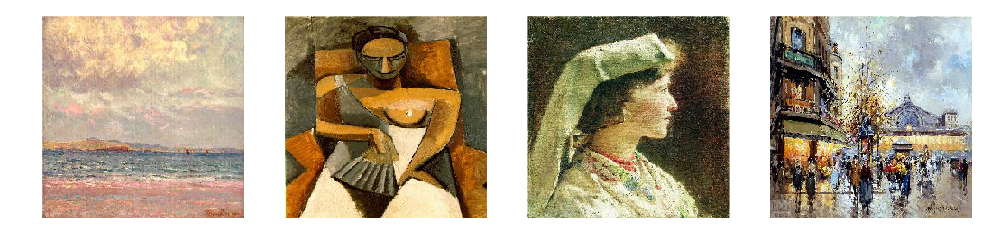

In [32]:
plots(img ,titles=None)

In [33]:
vgg.predict(img, True)

(array([ 0.9648,  1.    ,  0.7879,  1.    ], dtype=float32),
 array([158, 152, 158,  91]),
 ['1a8d67dbb446bdc4298cc0be56932a38',
  '1950e9aa6ad878bc2a330880f77ae5a1',
  '1a8d67dbb446bdc4298cc0be56932a38',
  '0f05ba8fe45bc6e464a4a35a85d060d2'])